# Fraud Detection: Data Wrangling

- Data Visualization, EDA, and cleaning
    - Credit to https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
    - and to https://www.kaggle.com/hazratnit/credit-fraud-detection
    - easy/difficult visualization from https://www.researchgate.net/publication/283349138_Calibrating_Probability_with_Undersampling_for_Unbalanced_Classification (Section III-D)
    - Data has already been run through PCA, except for "Time" and "Amount" which will need to be scaled to match the remaining columns
    - Do the usual checking for nulls, describe T/A columns, visualize
    - State mean/min/max of amount; percentage positive/negative
    - Do correlation heatmap
    - Do boxplots of highly positive/negative correlations
    - Do easy/difficult histplots of the high correlations
    - Consider outlier correction
- Dataset from: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
# load data and import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

df = pd.read_csv('data\creditcard.csv')

In [2]:
# Do the usual checking for nulls, describe T/A columns, visualize
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
df[['Time','Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


Since data has already been run through PCA, there are no nulls. Of note is the big outlier (?) in "amount", where the mean is above the 75% quartile and the max is orders of magnitude larger than anything else.

<AxesSubplot:xlabel='Time', ylabel='Count'>

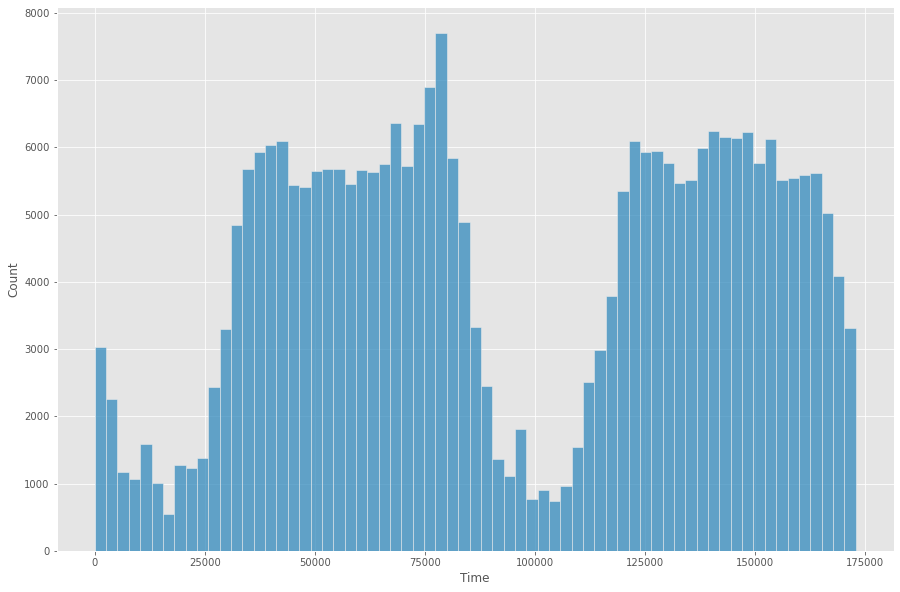

In [17]:
plt.figure(figsize=(15,10))
sns.histplot(df['Time'])

D:\Documents\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Amount', ylabel='Density'>

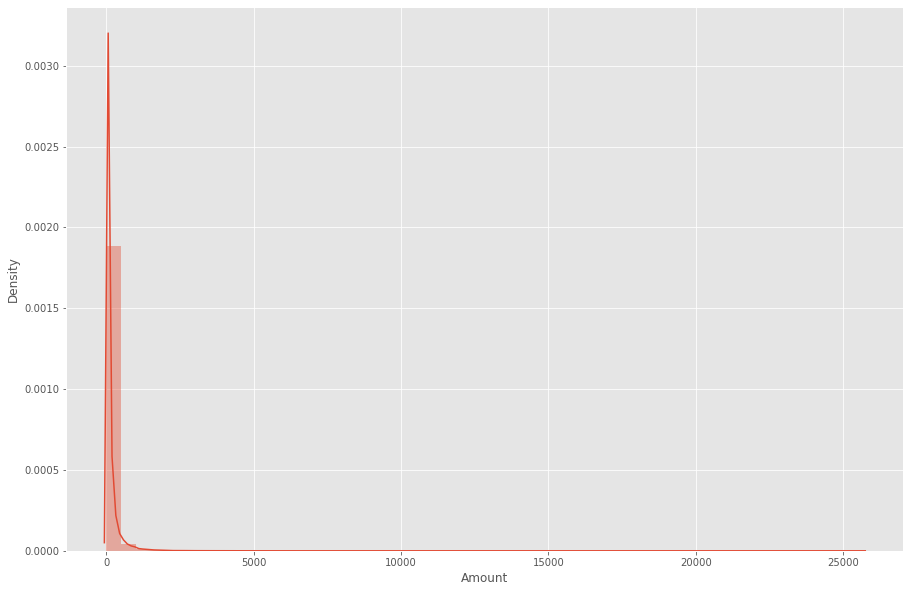

In [19]:
plt.figure(figsize=(15,10))
sns.distplot(df['Amount'])

In [14]:
# Class balance evaluation
classcount = df.Class.value_counts()
perc_pos = (classcount[1]/(classcount[0]+classcount[1]))*100
print("Data contains {} fraudulent transactions which are {:.3f}% of all transactions".format(classcount[1], perc_pos))

Data contains 492 fraudulent transactions which are 0.173% of all transactions


<AxesSubplot:>

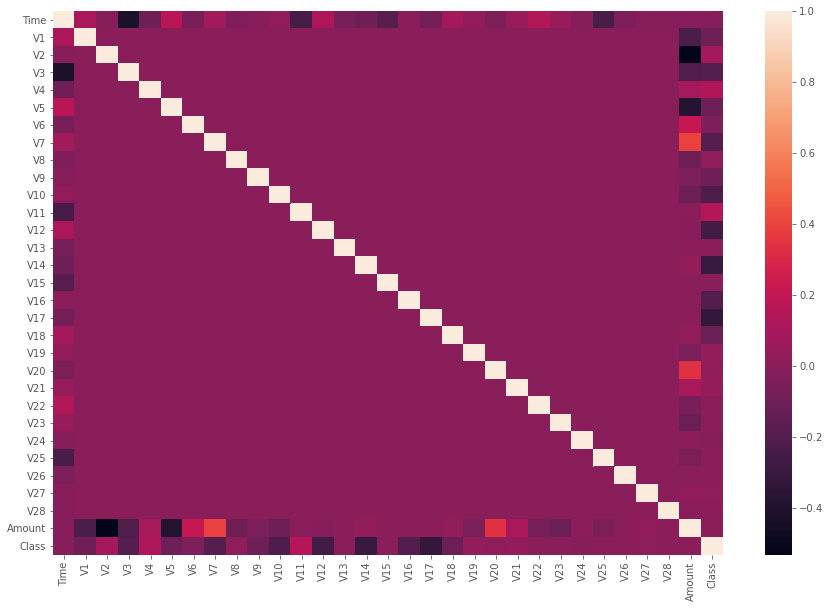

In [21]:
# Do correlation heatmap
corr = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr)

In [29]:
corr[corr.Class < -0.3]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
V14,-0.098757,-5.020280e-16,-1.730566e-16,4.739859e-16,2.282280e-16,6.565143e-16,2.621312e-16,2.607772e-16,-8.599156e-16,3.784757e-15,...,-3.356561e-16,3.740383e-16,3.883204e-16,2.003482e-16,-8.547932e-16,-1.660327e-16,1.044274e-16,2.289427e-15,0.033751,-0.302544
V17,-0.073297,-3.879840e-16,-2.685296e-16,7.614712e-16,-2.699612e-16,1.281914e-16,2.015618e-16,2.177192e-16,-2.269549e-16,1.113695e-15,...,-8.230527e-16,-8.743398e-16,3.706214e-16,-2.403828e-16,2.666806e-16,6.932833e-16,6.148525e-16,-5.534540e-17,0.007309,-0.326481


In [30]:
corr[corr.Class > 0.3]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Class,-0.012323,-0.101347,0.091289,-0.192961,0.133447,-0.094974,-0.043643,-0.187257,0.019875,-0.097733,...,0.040413,0.000805,-0.002685,-0.007221,0.003308,0.004455,0.01758,0.009536,0.005632,1.0


Not much correlation, which I expected, but keep an eye on features V14 and V17. Will re-check correlation on subsampled data.

<AxesSubplot:xlabel='Class', ylabel='V17'>

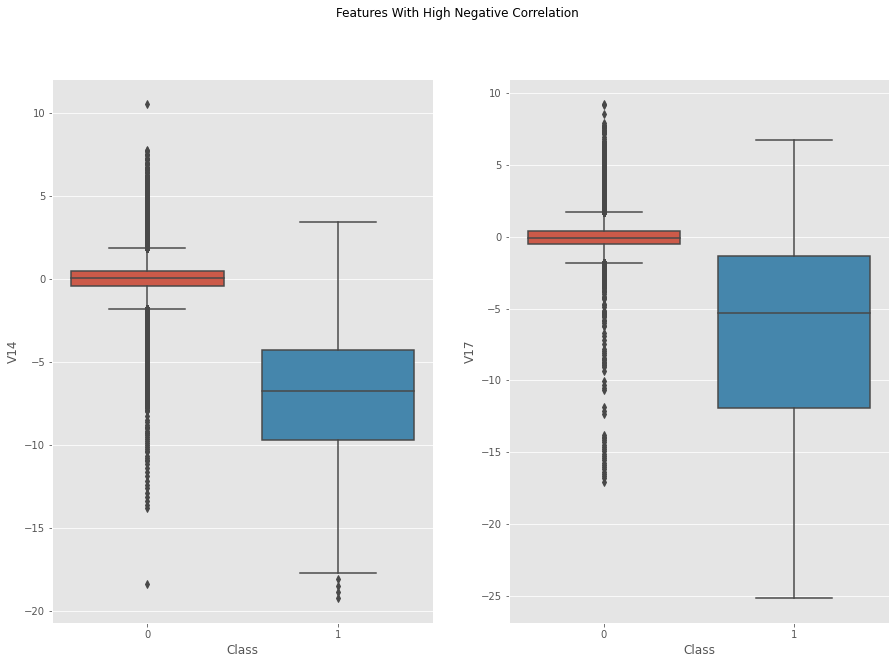

In [32]:
# Do boxplots of highly positive/negative correlations
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

f.suptitle('Features With High Negative Correlation')
sns.boxplot(x="Class", y="V14", data=df, ax=axes[0])
sns.boxplot(x="Class", y="V17", data=df, ax=axes[1])


Interesting... really compressed IQR for the negative class (non-fraud) but a whole lot of outliers; positive class distribution is lower and much larger range. I wonder what some of the others look like?

<AxesSubplot:xlabel='Class', ylabel='Amount'>

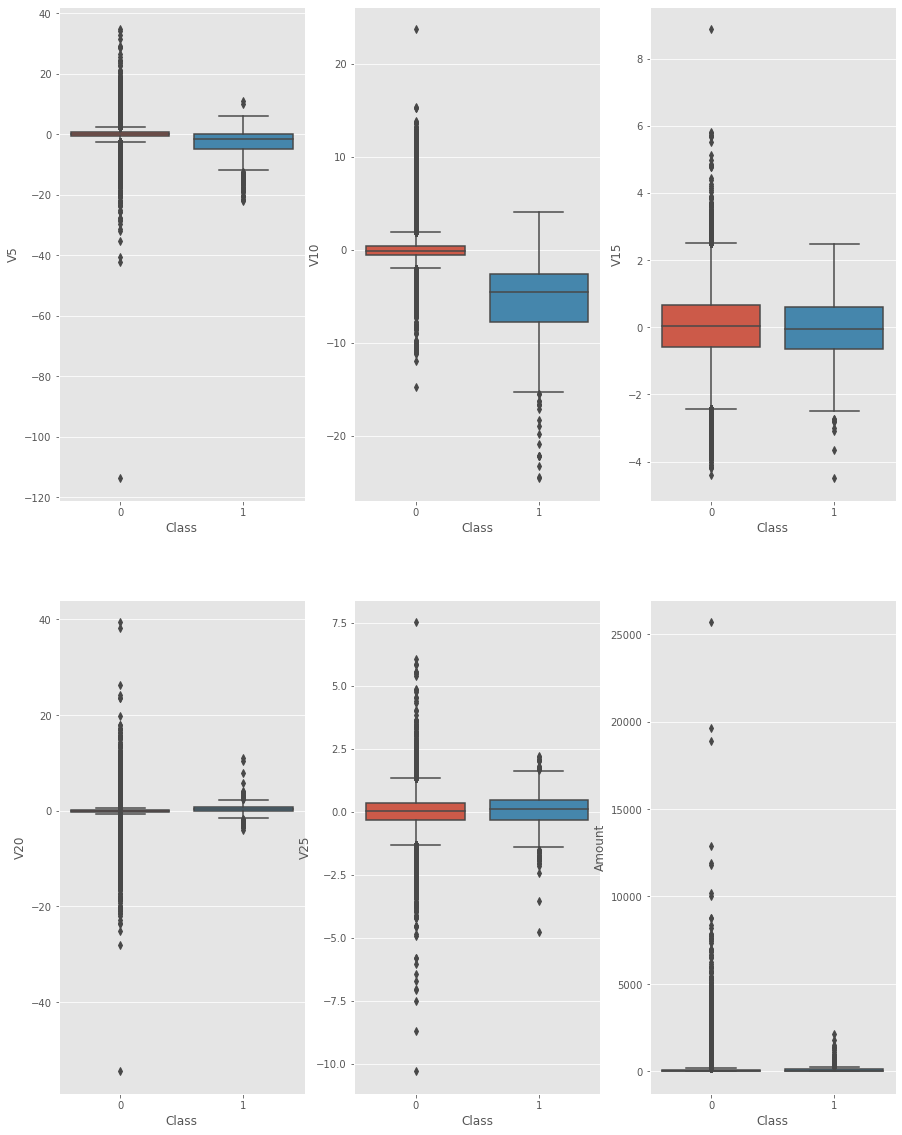

In [34]:
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,20))

sns.boxplot(x="Class", y="V5", data=df, ax=axes[0,0])
sns.boxplot(x="Class", y="V10", data=df, ax=axes[0,1])
sns.boxplot(x="Class", y="V15", data=df, ax=axes[0,2])
sns.boxplot(x="Class", y="V20", data=df, ax=axes[1,0])
sns.boxplot(x="Class", y="V25", data=df, ax=axes[1,1])
sns.boxplot(x="Class", y="Amount", data=df, ax=axes[1,2])

Feature V10 appears to have a similar pattern, and is (relatively) strongly correlated to Class. Also of note, looks like I will need to consider outlier management.

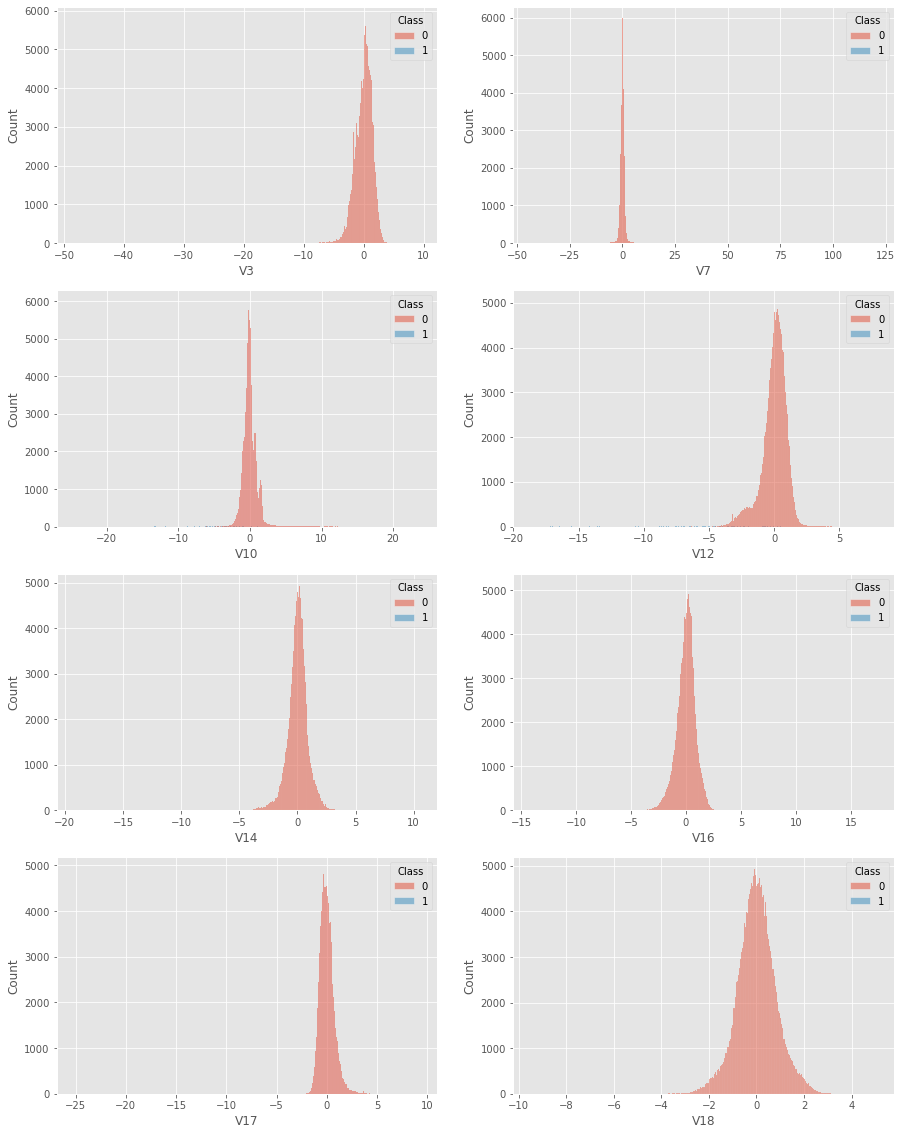

In [38]:
# A crack at "easy/difficult" detection of feature separation by class.
mostcorr = ['V3','V7','V10','V12','V14','V16','V17','V18']

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
row = 0
col = 0
for feature in mostcorr:
    sns.histplot(data=df, x=feature, hue='Class', ax=axes[row,col])
    col += 1
    if col > 1:
        col = 0
        row += 1

Of course, the classes are so imbalanced right now that I can't actually see the positive class on the graphs. Let's try redoing these when I have done subsampling.